# Producir dataset para entrenamiento

### Nota Importante

Los datos recopilados fueron obtenidos durante Febrero de 2020, los precios, el kilometraje y el listado de vehículos es altamente probable que hayan cambiado desde entonces por el uso que hayan dado a cada vehículo, las ventas que se hayan concretado, vehículos nuevos anunciados y/o por factores macroeconómicos que impacten a México.

## Análisis preliminar

Antes de decidir qué información utilizar para predecir el precio de un auto, hace falta analizar qué información se tiene.

In [1]:
#Importar pandas para cargar datos
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sb
from functools import reduce

In [2]:
#Leer archivo CSV.
#Eliminar columna de URL. Esta columna es exclusivamente para hacer referencia
#al anuncio original y es única para cada auto, por lo que no nos dice nada
#que pueda ayudar al algoritmo a generalizar cómo predecir el precio.
df = pd.read_csv("./carros_clean.csv", index_col=0).drop(['url'], axis=1)

In [3]:
#Vista previa de la información disponible en el DataFrame
df

,brand,model,version,year,km,price
0,ford,ikon,ambiente ac,2001,123467,31500
1,ford,focus,lx,2000,140000,33000
2,ford,sable,ls premium,2001,145630,33000
3,chevrolet,chevy sedan,1.6l monza,2001,147500,35000
4,ford,focus,ambiente,2001,219143,35000
...,...,...,...,...,...,...
12808,suzuki,ignis,5p glx 1.2l tm5 a/ac. aut. ve ra-16,2018,30000,2159200
12809,mercedes benz,clase g,500 4x4,2018,11582,2299000
12810,mercedes benz,maybach,s 650,2019,6807,2849900
12811,mercedes benz,amg gt,s,2019,2283,2999900


In [4]:
for c in df:
    print(df[c].describe(), "\n")

count          12812
unique            47
top       volkswagen
freq            1791
Name: brand, dtype: object 

count     12812
unique      529
top       jetta
freq        590
Name: model, dtype: object 

count     12812
unique     3671
top          lt
freq        164
Name: version, dtype: object 

count    12812.000000
mean      2014.958711
std          3.544637
min       2000.000000
25%       2013.000000
50%       2016.000000
75%       2017.000000
max       2019.000000
Name: year, dtype: float64 

count    1.281200e+04
mean     6.615675e+04
std      1.085522e+05
min      1.000000e+00
25%      3.039475e+04
50%      5.528000e+04
75%      8.600000e+04
max      1.000000e+07
Name: km, dtype: float64 

count    1.281200e+04
mean     2.615344e+05
std      2.000042e+05
min      3.200000e+03
25%      1.500000e+05
50%      2.150000e+05
75%      3.100000e+05
max      7.049000e+06
Name: price, dtype: float64 



### Variables numéricas Vs. Cadenas

Las columnas `year` y `km` contienen variables numéricas, lo que nos facilita mucho para un algoritmo de regresión lineal, ¿pero qué hay con las columnas `brand`, `model` y `version`? Finalmente, son las que contienen la información de qué tipo de carro es al que se hace referencia.

Es muy fácil imaginar los motivos que contribuyen a que un carro de marca Mercedes Benz o BMW será mucho más costoso que un Chevrolet, aunque sean del mismo año y tengan el mismo kilometraje, pero la regresión lineal solamente entiende de números, las letras, por su valor numérico en ASCII u otra forma de codificar las letras que forman el nombre de la marca, no significan mucho, ni se traducen en valores reales que influyen al precio del auto. Por ejemplo, el valor numérico de Ford por sus letras es menor que el de Chevrolet, sin embargo, es más común que los coches Chevrolet sean más baratos porque tienen más modelos de bajo costo (como Matiz, Chevy, o Spark), que la marca Ford. Y al mismo tiempo BMW tiene menos letras que Ford, pero es bien conocido que es una marca mucho más costosa en sus vehículos.

Habiendo dicho esto, ¿entonces qué hacemos para interpretar el significado de si un auto es de una marca u otra en forma numérica?

### Variables categóricas

La forma normal de visualizar los valores de cadena que representan *algo*, y que se repiten en una columna de nuestros datos es en forma de "categorías". Esto significa que las categorías se pueden representar con un número (e.g. Ford = 1, Chevrolet = 2, BMW = 3, etc.).

A su vez, estas variables pueden ser de dos tipos: ordinales y nominales. Las variables nominales son sólo "nombres", y las ordinales implican que hay un "orden" implícito en estas categorías. En nuestro caso, no hay un orden implícito, aunque queramos pensar que sí se pueden poner en una escala de las marcas menos costosas a las más costosas. La realidad es que como los precios cambian año con año, y cada que una marca saca un modelo distinto, necesitamos algo menos ambiguo, o menos cambiante para darle significado a nuestras categorías.

¿Y entonces? ¿Acaso no nos regresa esto que el nombre de la marca realmente no signifique nada? Pues sí, en este caso sólo tradujimos una cadena a un número de categoría, y como estamos tratando con más de dos marcas, y una variable nominal no dicotomizada (o no binaria), no nos ayuda mucho, necesitamos pensar en cómo dicotomizarla, para que cada peso que multiplique la variable que represente la marca del auto, se traduzca directamente en la influencia que tiene esta variable sobre el precio final.

### Dummy variables

Quizás la pregunta correcta no sea necesariamente `¿de qué marca es?` sino `¿es de marca 'XYZ' o no?`. Replanteando la pregunta de esta manera, podemos tener variables que son independientes una de la otra, y que contribuyen independientemente al precio final. Esto es, que separamos las marcas, para que cada una no sea afectada por las demás.

Lograr esto significa crear las llamadas `dummy variables` (o variables de paja / variables postizas). Esto se hace creando una variable por cada una de las categorías, haciéndolas dicótomas, y representadas exclusivamente por valores de `1` o `0`. En nuestro caso, si tuviéramos las 3 marcas: Kia, Ford y Chevrolet, cada una tendría su propia variable.

#### Categorías originales

|    Marca  |   Modelo  |  Precio |
|:---------:|:---------:|:-------:|
|   Kia     | Stinger   | 7049000 |
| Chevrolet |Chevy Sedán|  35000  |
| Ford      | Ikon      |  31500  |

#### Categorías dicotomizadas (dummy variables)

|  Kia  | Chevrolet | Ford |    Modelo  |  Precio |
|:-----:|:---------:|:----:|:----------:|:-------:|
| 1     | 0         |   0  |    Stinger | 7049000 |
| 0     | 1         |   0  | Chevy Sedán|  35000  |
| 0     | 0         |   1  |    Ikon    |  31500  |

Una vez que lo anterior se entiende, podemos entender cómo utilizar todas las categorías no ordinales para calcular los pesos que se relacionan con ellas, que también es el caso con el modelo y las versiones de los vehículos.

Veamos ahora cuántos valores tenemos para cada uno.

In [5]:
def carros_distintos(df):
    plotvals = pd.Series({
        "marcas": len(df.brand.unique()),
        "modelos": len(df.model.unique()),
    })
    if "version" in df:
        plotvals["versiones"] = len(df.version.unique())
    print(f"Tamaño del DataFrame: {df.shape}")
    print(plotvals)
    

carros_distintos(df)

Tamaño del DataFrame: (12812, 6)
marcas         47
modelos       529
versiones    3671
dtype: int64


47 marcas son un número considerable, 529 modelos para estas marcas significaría un número todavía mayor de variables dicótomas, que se traduciría en mayor necesidad de poder de computo para calcular los pesos en todas ellas, pero 3671 versiones para estos 530 modelos distintos, es casi como 1 de cada 4 dueños hubiera inventado su propia versión, y no representa necesariamente la versión real del vehículo. Esto es, que en lugar de ver para un modelo de Chevrolet las versiones `LS`, `LT` o `LTS` de un vehículo, vemos `Equipado AC Transmisión manual`. Si cada versión es lo que cada quién escribió con su palabra, no será tarea fácil generalizar a qué versión se refieren del vehículo, veamos qué debemos hacer al respecto.

### Encontrar valores anómalos y poco significativos

Hasta este punto sólo sabemos que todas las columnas en todas sus filas tienen un valor, pero no hemos encontrado qué otros casos de valores anómalos existen, además de lo que resalta a simple vista con las versiones, como mencionamos anteriormente. Quizás haya alguna marca que sólo tenga un vehículo, o un modelo con las letras al revés (Chvey en vez de Chevy, por ejemplo). Descartar algunos de estos, o corregirlos para agruparlos en la categoría correcta nos podría ahorras varias dimensiones, y eso nos ahorraría precioso poder de cómputo.

Empecemos por ver cuántos vehículos hay por marca.

volkswagen       1791
ford             1747
chevrolet        1461
nissan           1389
honda             718
mazda             567
toyota            472
dodge             437
audi              432
mercedes benz     421
jeep              387
bmw               383
renault           355
kia               311
seat              223
hyundai           206
mitsubishi        162
lincoln           134
chrysler          132
otros(28)        1084
dtype: int64


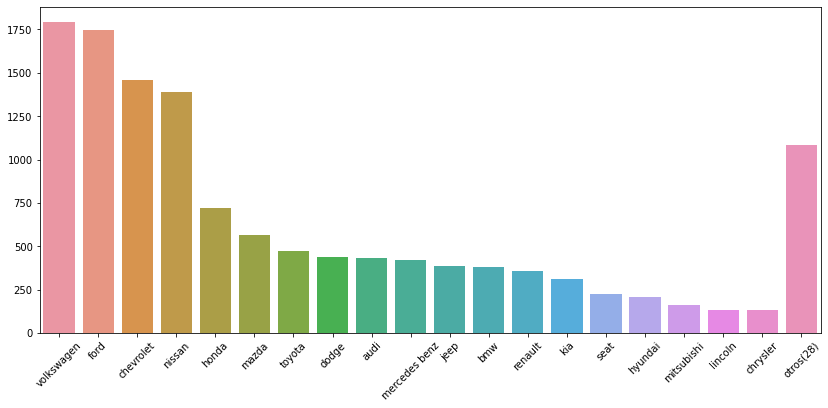

In [6]:
counts = df.brand.value_counts()
top20 = counts.nlargest(19)
otros = reduce(lambda x,y: x+y, counts[19:])
top20 = top20.append(pd.Series({f'otros({len(counts[19:])})': otros}))

print(top20)
#Mostrar gráfica de barra con mayores conteos
plt.figure(figsize=(14,6))
bp = sb.barplot(top20.index, top20.values)
_ = bp.set_xticklabels(bp.get_xticklabels(), rotation=45)

Para los fines de este caso de estudio, principalmente porque no me sobra el poder de cómputo con una computadora personal y sin tarjeta gráfica, conservaremos las marcas con más de 500 vehículos.

In [7]:
#Crear lista con marcas de autos que tengan más de 200 autos
mas_de_500 = [marca for marca, cuenta in counts.items() if cuenta > 500]

print(f"Marcas con carros únicos: {mas_de_500}")

print("\nAntes de filtrar:")
carros_distintos(df)

df = df[df.brand.isin(mas_de_500)]

print("\nRegistros filtrados:")
carros_distintos(df)

Marcas con carros únicos: ['volkswagen', 'ford', 'chevrolet', 'nissan', 'honda', 'mazda']

Antes de filtrar:
Tamaño del DataFrame: (12812, 6)
marcas         47
modelos       529
versiones    3671
dtype: int64

Registros filtrados:
Tamaño del DataFrame: (7673, 6)
marcas          6
modelos       173
versiones    1687
dtype: int64


Bueno, visto lo anterior, es entendible que no haya gente anunciando Lamborghinis y Ferraris por doquier en un sitio de venta de segunda mano.

Continuemos por realizar un ejercicio similar con las versiones, identifiquemos cuántas versiones por modelo hay, quizás podríamos concluir que las versiones no están tan alejadas entre sí y tienen muchas similitud que podríamos corregir si truncamos o corregimos parte del texto en la versión. Intentemos con una marca que no haya tenido demasiados modelos distintos a través de los años, como Mazda.

model   version                                          
2       5p hb i grand touring ta a/ac. aut. ve piel f. le    1
        5p i touring l4/1.5 man                              1
        i grand touring aut                                  8
        i touring                                            2
        i touring aut                                        7
                                                            ..
mx-5    i sport                                              7
        i sport convertible l4/2.0 man                       2
        rf aut                                               2
        sport                                                2
speed3  2.3l                                                 2
Length: 108, dtype: int64


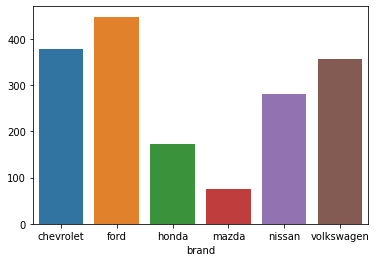

In [8]:
print(df[df.brand == 'mazda'].groupby(['model', 'version']).size())

agrupado = df.groupby('brand')['version'].apply(lambda x: len(x.unique()))
sb.barplot(agrupado.index, agrupado.values)

Las versiones ingresadas por los usuarios, efectivamente, tienen algunas similitudes, pero siguen siendo muy dispersas, y hacer un agrupamiento acertado de este tipo de información dispersa está fuera del alcance de este proyecto, sería casi un proyecto por sí solo. Así, pues, descartemos las versiones.

In [9]:
df = df.drop(['version'], axis=1)
df.head()

,brand,model,year,km,price
0,ford,ikon,2001,123467,31500
1,ford,focus,2000,140000,33000
2,ford,sable,2001,145630,33000
3,chevrolet,chevy sedan,2001,147500,35000
4,ford,focus,2001,219143,35000


### Agregar columnas significativas

Otra cosa que vale destacar es que, en este especifico caso, estamos lidiando con una variable numérica que por sí misma no es tan significativa tal y como está, porque el factor que deprecia al auto junto con el kilometraje, no es tal cual el año, sino la antigüedad, excepto en autos de colección (que no es el caso para este estudio). Agreguemos una columna para cuantificar esto, restándole el año actual a cada fila.

In [10]:
curr_year = datetime.datetime.now().year

#Restar el año actual a cada fila
df['y_old'] = curr_year - df['year']

#Reordenar columnas
df = df[['brand', 'model', 'y_old', 'km', 'price']]
df.head()

,brand,model,y_old,km,price
0,ford,ikon,19,123467,31500
1,ford,focus,20,140000,33000
2,ford,sable,19,145630,33000
3,chevrolet,chevy sedan,19,147500,35000
4,ford,focus,19,219143,35000


Habiendo una relación directa entre marca y modelo (otras marcas legalmente no pueden repetir modelos de otras marcas) podemos crear una columna nueva combinando la marca y modelo, separadas por un `_`.

In [11]:
df['brand_model'] = df['brand'] + '_' + df['model']

#Reordenar columnas
df = df[['brand', 'model', 'brand_model', 'y_old', 'km', 'price']]
df.head()

,brand,model,brand_model,y_old,km,price
0,ford,ikon,ford_ikon,19,123467,31500
1,ford,focus,ford_focus,20,140000,33000
2,ford,sable,ford_sable,19,145630,33000
3,chevrolet,chevy sedan,chevrolet_chevy sedan,19,147500,35000
4,ford,focus,ford_focus,19,219143,35000


Ya conseguimos reducir bastante las dimensiones de nuestro DataFrame, busquemos finalmente reducir los valores anómalos un poco más para tener valores que se puedan generalizar mejor basados en marca y modelo. Descartemos aquellos modelos que tengan menos de 10 ofertas.

Valores originales:
Tamaño del DataFrame: (7673, 6)
marcas       6
modelos    173
dtype: int64

Eliminar 70 modelos

Después de filtrar modelos:
Tamaño del DataFrame: (7440, 6)
marcas       6
modelos    103
dtype: int64


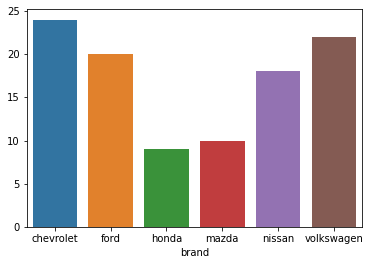

In [12]:
print("Valores originales:")
carros_distintos(df)

counts = df.brand_model.value_counts()
eliminar_modelos = [k for k,v in counts.items() if v < 10]
print(f"\nEliminar {len(eliminar_modelos)} modelos")
df = df[~df.brand_model.isin(eliminar_modelos)]

print("\nDespués de filtrar modelos:")
carros_distintos(df)
agrupado = df.groupby('brand')['model'].apply(lambda x: len(x.unique()))
sb.barplot(agrupado.index, agrupado.values)

## Ahora sí el Dataset de entrenamiento

Una vez que limpiamos suficiente la información podemos obtener nuestras variables dicotomizadas.

In [13]:
#Obtener dummy variables
training_df = pd.get_dummies(df['brand_model'])
training_df.head()

,chevrolet_aveo,chevrolet_beat,chevrolet_camaro,chevrolet_captiva sport,chevrolet_cavalier,chevrolet_chevy,chevrolet_cheyenne,chevrolet_colorado,chevrolet_corsa,chevrolet_cruze,...,volkswagen_pointer,volkswagen_polo,volkswagen_polo hatchback,volkswagen_saveiro,volkswagen_teramont,volkswagen_tiguan,volkswagen_touareg,volkswagen_transporter,volkswagen_up!,volkswagen_vento
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Ahora concatenemos las dummy variables con las variables numéricas, y guardemos el resultado en un nuevo DataFrame

In [14]:
num_cols = ['y_old', 'km', 'price']
training_df = pd.concat([training_df, df[num_cols]], axis=1)

training_df.head()

,chevrolet_aveo,chevrolet_beat,chevrolet_camaro,chevrolet_captiva sport,chevrolet_cavalier,chevrolet_chevy,chevrolet_cheyenne,chevrolet_colorado,chevrolet_corsa,chevrolet_cruze,...,volkswagen_saveiro,volkswagen_teramont,volkswagen_tiguan,volkswagen_touareg,volkswagen_transporter,volkswagen_up!,volkswagen_vento,y_old,km,price
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,19,123467,31500
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,20,140000,33000
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,19,219143,35000
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,20,100000,38000
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,19,155000,39000


## Guardar como CSV

Y finalmente, una vez generado nuestro DataFrame, creemos el archivo `.csv` con estos datos.

In [15]:
print(f"Tamaño final del dataset: {training_df.shape}")
training_df.to_csv('carros_training.csv')

Tamaño final del dataset: (7440, 106)
